# Conditioning and Stability
In this project the goal was to analyze the conditioning of core problems like solving linear systems, finding roots, and computing eigenvalues.

In [1]:
import numpy as np
import sympy as sy
from scipy import linalg as la
from matplotlib import pyplot as plt

Matplotlib is building the font cache; this may take a moment.


## Condition number via singular values

The function computes the condition number of a matrix with respect to the two norm using its singular values. A condition number measures how sensitive the solution of a linear system is to small perturmations in the inputs. Large values are bad.

In [7]:
def matrix_cond(A):
    """Calculates the condition number of a matrix A with respect to the 2-norm."""
    sv = la.svdvals(A)
    max_sv = sv[0]
    min_sv = sv[-1]
    if np.allclose(min_sv, 0):
        return np.inf
    return max_sv / min_sv

In [8]:
# Example: Condition number of a simple matrix

# Well-conditioned 2x2 matrix
A = np.array([[1, 0], [0, 1]])
print("Condition of A =", matrix_cond(A))

# Ill-conditioned 2x2 matrix (columns nearly dependent)
B = np.array([[1, 1], [1, 1.0000000001]])
print("Condition of B =", matrix_cond(B))


Condition of A = 1.0
Condition of B = inf


This should result in:
Condition of A = 1.0
Condition of B = inf

*Note the significant difference in values*

## Example: Conditioning of the Wilkinson polynomial roots
This example shows how tiny perturmations in the coefficiencts of the Wilkinson polynomial dramatically change its roots... so this is an ill-conditioned root-finding problem.

In [18]:
# Problem 2
def wilkpoly():
    """Randomly perturbs the coefficients of the Wilkinson polynomial by
    replacing each coefficient c_i with c_i*r_i, where r_i is drawn from a
    normal distribution centered at 1 with standard deviation 1e-10.

    Returns:
        (float) The average absolute condition number.
        (float) The average relative condition number.
    """
    w_roots = np.arange(1, 21)

    # Get the exact Wilkinson polynomial coefficients using SymPy.
    x, i = sy.symbols('x i')
    w = sy.poly_from_expr(sy.product(x-i, (i, 1, 20)))[0]
    w_coeffs = np.array(w.all_coeffs())

    n = np.size(w_coeffs)

    abs_conds = []
    rel_conds = []
    
    for _ in range(100):
        # multiply each c_i by r_i
        r_i = np.random.normal(1, 1 * 10**(-10), n)
        peturbed_coeff = r_i * w_coeffs

        new_roots = np.roots(np.poly1d(peturbed_coeff))

        w_roots = np.sort(w_roots)
        new_roots = np.sort(new_roots)

        # Absolute Condition Number
        absolute = la.norm(new_roots - w_roots, np.inf) / la.norm((peturbed_coeff - w_coeffs), np.inf)

        # Relative Condition Number
        relative = absolute * la.norm(w_coeffs, np.inf) / la.norm(w_roots, np.inf)

        abs_conds.append(absolute)
        rel_conds.append(relative)

        plt.scatter(np.real(new_roots), np.imag(new_roots), marker=',', color='black', s=.65, alpha=0.5)


    plt.plot(np.real(w_roots), np.imag(w_roots), 'bo', label="Unperturbed roots")
    plt.title("Roots of the Wilkinson polynomial under random perturbations")
    plt.xlabel("Real part")
    plt.ylabel("Imaginary part")
    plt.legend()
    plt.grid(True)
    plt.savefig('WilkPoly.png')

    return np.mean(abs_conds), np.mean(rel_conds)

(3.61639149385105e-9, 2495989967.81148)

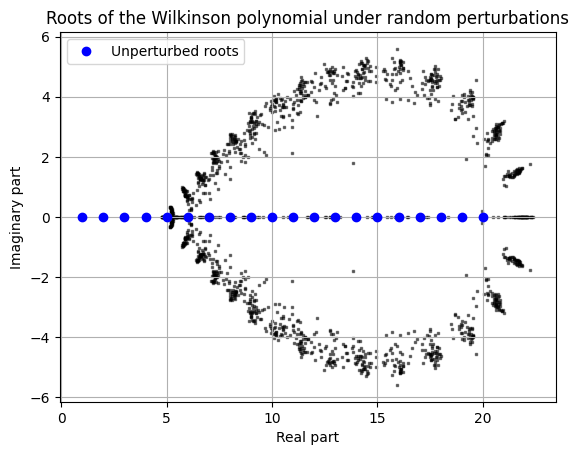

In [19]:
wilkpoly()

In [21]:
# Helper function
def reorder_eigvals(orig_eigvals, pert_eigvals):
    """Reorder the perturbed eigenvalues to be as close to the original eigenvalues as possible.
    
    Parameters:
        orig_eigvals ((n,) ndarray) - The eigenvalues of the unperturbed matrix A
        pert_eigvals ((n,) ndarray) - The eigenvalues of the perturbed matrix A+H
        
    Returns:
        ((n,) ndarray) - the reordered eigenvalues of the perturbed matrix
    """
    n = len(pert_eigvals)
    sort_order = np.zeros(n).astype(int)
    dists = np.abs(orig_eigvals - pert_eigvals.reshape(-1, 1))
    for _ in range(n):
        index = np.unravel_index(np.argmin(dists), dists.shape)
        sort_order[index[0]] = index[1]
        dists[index[0], :] = np.inf
        dists[:, index[1]] = np.inf
    return pert_eigvals[sort_order]

## Conditioning of the eigenvalue problem
This function extimates how sensitive the eigenvalues of a matrix are to small complex perturmations. 

In [32]:

def eig_cond(A):
    """Approximate the condition numbers of the eigenvalue problem at A.

    Parameters:
        A ((n,n) ndarray): A square matrix.

    Returns:
        (float) The absolute condition number of the eigenvalue problem at A.
        (float) The relative condition number of the eigenvalue problem at A.
    """
    reals = np.random.normal(0, 1e-10, A.shape)
    imags = np.random.normal(0, 1e-10, A.shape)
    H = reals + 1j*imags

    eig_A = la.eigvals(A)
    eig_AH = reorder_eigvals(eig_A, la.eigvals(A + H))

    absolute = la.norm(eig_A - eig_AH, 2) / la.norm(H, 2)
    relative = (la.norm(A, 2) / la.norm(eig_A, 2)) * absolute

    return absolute, relative

# Example: Eigenvalue conditioning of a 2×2 matrix

A = np.array([[2.0, 1.0],
              [0.0, 2.0]])

abs_cond, rel_cond = eig_cond(A)
print("Absolute eigenvalue condition number:", abs_cond)
print("Relative eigenvalue condition number:", rel_cond)


Absolute eigenvalue condition number: 83611.3359976643
Relative eigenvalue condition number: 75722.24542526978


## Problem 4 – Conditioning over a parameter grid

Here the conditioning of the eigenvalue problem is explored for a simple 2×2 matrix over a grid of values.  
For each point in the domain the relative eigenvalue condition number is computed using `eig_cond`, then `plt.pcolormesh` visualizes how conditioning changes across the plane, revealing regions where the eigenvalues are stable versus extremely sensitive. 

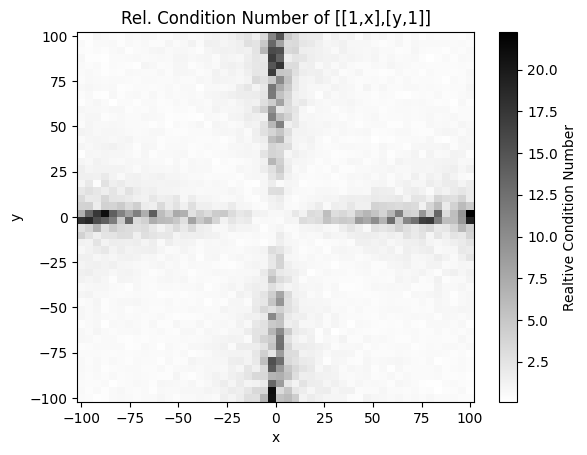

In [34]:
# Problem 4
def prob4(domain=[-100, 100, -100, 100], res=50):
    """Create a grid [x_min, x_max] x [y_min, y_max] with the given resolution. For each
    entry (x,y) in the grid, find the relative condition number of the
    eigenvalue problem, using the matrix   [[1, x], [y, 1]]  as the input.
    Use plt.pcolormesh() to plot the condition number over the entire grid.

    Parameters:
        domain ([x_min, x_max, y_min, y_max]):
        res (int): number of points along each edge of the grid.
    """
    # Build or x and y domain
    x = np.linspace(domain[0], domain[1], res)
    y = np.linspace(domain[2], domain[3], res)

    n = len(x)

    # Array to be filled with relative condition values
    Z = np.zeros((n, n))

    # Find the realtive condition value for each x, y combination
    for i in range(n):
        for j in range(n):
            Z[j, i] = (eig_cond(np.array(([[1, x[i]], [y[j], 1]])))[1])

    # Plotting
    plt.pcolormesh(x, y, Z, cmap='gray_r', shading='auto')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.colorbar(label='Realtive Condition Number')
    plt.title('Rel. Condition Number of [[1,x],[y,1]]')

    plt.savefig('Prob_4.png')
prob4()


## Problem 5 – Stability of least squares via normal equations vs QR

This problem compares two ways of solving a polynomial least squares fit and highlights the numerical stability advantages of QR over the normal equations.   
Given data from `stability_data.npy`, the code builds a Vandermonde matrix, solves the least squares problem once with the normal equations and once with a QR factorization, computes the forward error for both, and plots the data together with the two fitted polynomials to show how the solution method affects accuracy and stability. 


In [36]:
# Problem 5
def prob5(n):
    """Approximate the data from "stability_data.npy" on the interval [0,1]
    with a least squares polynomial of degree n. Solve the least squares
    problem using the normal equation and the QR decomposition, then compare
    the two solutions by plotting them together with the data. Return
    the mean squared error of both solutions, ||Ax-b||_2.

    Parameters:
        n (int): The degree of the polynomial to be used in the approximation.

    Returns:
        (float): The forward error using the normal equations.
        (float): The forward error using the QR decomposition.
    """
    # Load Data
    xk, yk = np.load("stability_data.npy").T
    A = np.vander(xk, n + 1)

    b = yk

    # Solve normal equation
    ATA = A.T @ A
    ATb = A.T @ b
    x_normal = la.inv(ATA) @ ATb

    # Solve QR Decomposition
    Q, R = la.qr(A, mode='economic')
    x_qr = la.solve_triangular(R, Q.T @ b)

    # Calculate Errors
    err_normal = la.norm(A @ x_normal - b, 2)
    err_qr = la.norm(A @ x_qr - b, 2)

    # Plotting
    x = np.linspace(0, 1, 500)
    y_normal = np.polyval(x_normal, x)
    y_qr = np.polyval(x_qr, x)

    plt.scatter(xk, yk, label='data', color='black')
    plt.plot(x, y_normal, label='normal', color='blue', ls='-')
    plt.plot(x, y_qr, label='qr', color='red', ls='-.')
    plt.legend()
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Least Squares Polynomial for Different Methods')
    plt.savefig('Prob5.png')

    return err_normal, err_qr
prob5(10)


FileNotFoundError: [Errno 2] No such file or directory: 'stability_data.npy'